# Library import

In [23]:
import numpy as np
import pandas as pd
from scipy.stats import norm

import matplotlib.pyplot as plt
%matplotlib inline

# Define Constant & Load Binomial Populational

In [16]:
B = 50000
alpha = 0.05

In [2]:
n_population = 500
X = pd.Series(np.random.binomial(10000, 0.7, size=n_population))
X.head()

0    7046
1    7029
2    7050
3    6905
4    6959
dtype: int64

In [4]:
y1 = np.repeat("true", n_population/2) 
y2 = np.repeat("false", n_population/2)

n_true = len(y1)
n_false = len(y2)

print(f"Size of true target: {n_true}")
print(f"Size of false target: {n_false}")

Size of true target: 250
Size of false target: 250


# Define the dataset

In [5]:
y = pd.Series(np.append(y1, y2))
y.head()

0    true
1    true
2    true
3    true
4    true
dtype: object

In [6]:
df = pd.concat([X, y], axis=1)
df.head()

,0,1
0,7046,true
1,7029,true
2,7050,true
3,6905,true
4,6959,true


# Get Mean and Median of the Sample

In [10]:
means_p_group = df.groupby(1, group_keys=False)[0].mean()
means_p_group

1
false    6996.172
true     6997.136
Name: 0, dtype: float64

In [11]:
medians_p_group = df.groupby(1)[0].median()

medians_p_group

1
false    6993.0
true     6996.0
Name: 0, dtype: float64

# Apply Bootstrapping

In [13]:
def bootstrapping_means_medians_diff(df: pd.DataFrame, B: int):
    bs_mean_diff = []
    bs_medians_diff = []

    bs_means_true = []
    bs_means_false = []

    coun_pos_meandiff, coun_pos_mediandiff = 0, 0
    
    for i in range(B):

        bs_sample = df.sample(frac=1, replace=True)

        # means/medians of bs sample for control and exp group
        bs_means_p_group = bs_sample.groupby(1)[0].mean()
        bs_medians_p_group = bs_sample.groupby(1)[0].median()
        bs_sample_mean_true = bs_means_p_group["true"]
        bs_sample_mean_false = bs_means_p_group["false"]

        bs_means_true.append(bs_sample_mean_true)
        bs_means_false.append(bs_sample_mean_false)

        # calc the diff in means/medians p/ bs sample
        diff_means = bs_sample_mean_false - bs_sample_mean_true
        diff_medians = bs_medians_p_group["false"] - bs_medians_p_group["true"]
        

        # counting the numb of times the diff is pos
        if (diff_means > 0):
            coun_pos_meandiff += 1

        if (diff_medians > 0):
            coun_pos_mediandiff += 1

        bs_mean_diff.append(diff_means)
        bs_medians_diff.append(diff_medians)
    
    return bs_means_true, bs_means_false, coun_pos_meandiff, coun_pos_mediandiff, bs_mean_diff, bs_medians_diff

        
        

In [15]:
X_bars_true, X_bars_false, n_means, n_medians, bs_mean_diff, bs_median_diff = bootstrapping_means_medians_diff(
    df, B
)

# Calculating Mean, Standard Error, and Confidence Interval - CI

In [17]:
Z_mean = np.mean(X_bars_false) - np.mean(X_bars_true)
Z_sigma = np.sqrt((np.var(X_bars_false)/n_false + np.var(X_bars_true)/n_true))
confidence_interval = [Z_mean - norm.ppf(1-alpha/2)*Z_sigma, Z_mean + norm.ppf(1-alpha/2)*Z_sigma]

print(f"Mean of X_bars_false - X_bars_true: {Z_mean}")
print(f"Standar Error of X_bars_false - X_bars_true: {Z_sigma}")
print(f"CI of X_bars_false - X_bars_true: {confidence_interval}")

Mean of X_bars_false - X_bars_true: -0.9758949514007327
Standar Error of X_bars_false - X_bars_true: 0.26724505168499074
CI of X_bars_false - X_bars_true: [-1.4996856277498598, -0.45210427505160555]


# Calculating Percentile

In [22]:
# 0th percentile
MIN = sorted(bs_mean_diff)[0]
# 100th percentile
MAX = sorted(bs_mean_diff)[-1]
# 5th percentile
percentile_5 = sorted(bs_mean_diff)[int(5/100 * (len(bs_mean_diff)-1))]
# 50th percentile/median
percentile_50_median = sorted(bs_mean_diff)[int(50/100) * (len(bs_mean_diff)-1)]
# 95.5th percentile
percentile_95_5 = sorted(bs_mean_diff)[int(95.5/100) * (len(bs_mean_diff)-1)]

print(f"0th percentile: {MIN}")
print(f"5th percentile: {percentile_5}")
print(f"50th percentile / median: {percentile_50_median}")
print(f"95.5th percentile: {percentile_95_5}")
print(f"100th percentile: {MAX}")

0th percentile: -19.547502840408924
5th percentile: -7.914331593737188
50th percentile / median: -19.547502840408924
95.5th percentile: -19.547502840408924
100th percentile: 17.53120798924465


# Visualize the Bootstraping Meand and Median Difference

In [34]:
def plot_bs_mean_median_diff():
    fig = plt.figure(figsize=(12, 5))
    counts, bins, ignored = plt.hist(bs_mean_diff, 100, density=True, color="gray")
    plt.xlabel("Mean Difference")
    plt.title("Distribution of Bootstrapped samples mean difference")

    plt.axvline(MIN, 0, 1, label="0th percentile", color="blue")
    plt.axvline(percentile_5, 0, 1, label="5th percentile", color="orange")
    plt.axvline(Z_mean, 0, 1, label="mean of Z = X_bars_false - X_bars_true", color='green', linewidth=5)
    plt.axvline(percentile_50_median, 0, 1, label="50th percentile/median", color="red")
    plt.axvline(percentile_95_5, 0, 1, label="95.5th percentile", color="purple")
    plt.axvline(MAX, 0, 1, label="100th percentile", color="brown")
    plt.legend()
    plt.show()

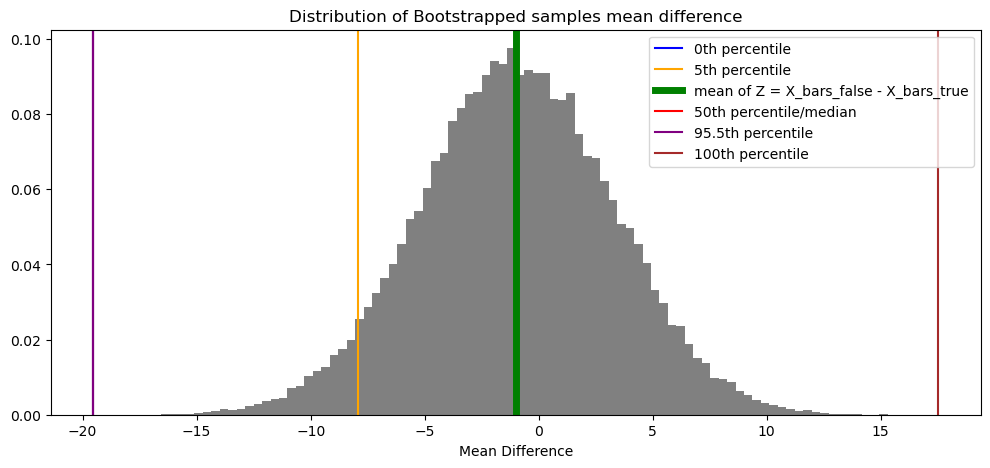

In [35]:
plot_bs_mean_median_diff()